# definitely not production code

In [1]:
# from common import *
# from pandas.api.types import CategoricalDtype
# import warnings 
# warnings.filterwarnings('ignore')
# debug = O()
# %matplotlib inline
# canvas(12,12)

In [2]:
# ho_time = pd.Timestamp('2015-07-01',tz='UTC')

# def fake(*,M,N):
#     M_, N_ = M, N
#     for time, M in M_.groupby('time'):
#         if time<ho_time:
#             continue
#         M['quarter'] = M.time.dt.year+(M.time.dt.quarter-1)/4
#         P = M[excluded_columns]
#         M = M.drop(columns=['returnsOpenNextMktres10','quarter'])
#         P['confidenceValue'] = 0.
#         yield M, None, P

# #################################################### START HERE

In [3]:
import pandas as pd
M = pd.read_pickle('../data/given/M.pkl')
N = None #pd.read_pickle('../data/given/N.pkl')
#test = pd.read_pickle('../data/given/test.pkl')

In [4]:
class __env__():
    _submitted = []
    # -1 = begin, 0 = just yielded, 1 = just predicted, -2 = finished, -3 = finished and submission file written too
    _states = [-1]
    
    class KaggleEnvError(Exception):
        pass
    
    @staticmethod
    def get_training_data():
        return M, N
    
    @staticmethod
    def get_prediction_days():
        env = __class__
        
        class iter_get_prediction_days():
            def __iter__(self):
                if env._states[-1] != -1:
                    raise env.KaggleEnvError('can only call get_prediction_days once!')
                
                env._days_iter = test.__iter__()
                return self
            
            def __next__(self):
                if env._states[-1] == 0:
                    raise env.KaggleEnvError('can only yield next day after the previous day was submitted')
                elif env._states[-1] not in [-1, 1, -2, -3]:
                    raise env.KaggleEnvError(
                        'environment internal error [bad state {} for __next__]'.format(env._states[-1]))
                
                try:
                    ret = env._days_iter.__next__()
                except StopIteration:
                    if env._states[-1] not in [-2, -3]:
                        env._states.append(-2)
                    raise
                
                env._states.append(0)
                return ret
        
        return iter_get_prediction_days()
            
    @staticmethod
    def predict(p):
        env = __class__
        if env._states[-1] == 1:
            raise env.KaggleEnvError('must get next prediction day before submitting a prediction again')
        elif env._states[-1] == -1:
            raise env.KaggleEnvError('must get next prediction day before submitting a prediction')
        elif env._states[-1] in [-2, -3]:
            raise env.KaggleEnvError('cannot submit prediction, every prediction has already been submitted')
        elif env._states[-1] != 0:
            raise env.KaggleEnvError('environment internal error [bad state {}]'.format(env._states[-1]))
        env._submitted.append(p)
        env._states.append(1)
        
    @staticmethod
    def write_submission_file():
        env = __class__
        if env._states[-1] not in [-2, -3]:
            raise env.KaggleEnvError('must be finished predicting before writing submission file')
            
        template = pd.concat((day[2] for day in test), axis=0)
        try:
            submission = pd.concat((sub for sub in env._submitted), axis=0)
            assert (template.shape==submission.shape), 'submissions have malformed shape'
            assert (template.index==submission.index).all(), 'submissions have malformed index'
            assert (template.columns==submission.columns).all(), 'submissions have malformed columns'
            assert (template.assetCode==submission.assetCode).all(), 'submissions have malformed assetCode column'
        except Exception as e:
            raise env.KaggleEnvError(e)
        
        env._submission = submission
        if env._states[-1] != -3:
            env._states.append(-3)
        print('''Your submission file has been saved. Once you `Commit` your Kernel and it finishes running, '''+
                '''you can submit the file to the competition from the Kernel Viewer `Output` tab.''')

# +++++++++++++++++++++ production additions ++++++++++++++++++++++

### imports

In [5]:
import numpy as np
import pandas as pd

import random, math, functools, itertools, os, gc
from collections import Counter, namedtuple

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
#import altair as alt
#from altair import *
#sns.set()
plt.style.use(['classic', 'seaborn', 'seaborn-colorblind'])

def canvas(width, height):
    dpi = 96
    from pylab import rcParams
    rcParams['figure.figsize'] = width, height
    
import lightgbm as lgb

### `utility.py`

In [6]:
from itertools import chain
from importlib import reload
from functools import wraps, reduce

class Cache(dict):
    __slots__ = ('function',)

    def __init__(self, function):
        self.function = function
    
    def __getitem__(self, args):
        if not isinstance(args, tuple):
            args = (args,)
        if args not in self:
            super().__setitem__(args, self.function(*args))
        return super().__getitem__(args)

    def __setitem__(self, *args, **kwargs):
        raise TypeError("Cannot set value to Cache object")


def memoized(function):
    '''Use as decorator
    DOES NOT SUPPORT kwargs for function! Will ignore all kwargs.
    '''
    cache = Cache(function)
    @wraps(function)
    def memoized(*args):
        return cache[args]
    memoized.cache = cache
    return memoized

### `object.py`

In [7]:
import collections

def _mydict_init_items_(*args, **kwargs):
    items = ()
    if len(args) == 3:
        space = args[2]
        for k in list(space.keys()):
            if str.startswith(k, '__') and str.endswith(k, '__'):
                del space[k]
        items = space.items()
    elif args and isinstance(args[0], collections.Mapping):
        items = args[0].items()
    elif args and isinstance(args[0], collections.Iterable):
        items = args[0]
    if kwargs:
        items = chain(items, kwargs.items())
    return items

def _mydict_pretty_factory_(start='{', end='}', relater=': ', delimiter=',',
                            key_action=lambda p, k: p.pretty(k), base=None):
    def _repr_pretty_(obj, p, cycle):
        nonlocal start, end, relater, delimiter, key_action, base
        typ = type(obj)

        beginning = typ.__name__ + '(' + start
        ending = end + ")"

        if typ is not base and typ.__repr__ != base.__repr__:
            # If the subclass provides its own repr, use it instead.
            return p.text(typ.__repr__(obj))

        if cycle:
            return p.text(beginning + '...' + ending)
        p.begin_group(1, beginning)
        keys = typ.keys(obj)
        # if dict isn't large enough to be truncated,
        #   sort keys before displaying
        if not (p.max_seq_length and len(obj) >= p.max_seq_length):
            try:
                keys = sorted(keys)
            except Exception:
                # Sometimes the keys don't sort.
                pass
        for idx, key in p._enumerate(keys):
            if idx:
                p.text(delimiter)
                p.breakable()
            key_action(p, key)
            p.text(relater)
            p.pretty(obj[key])
        p.end_group(1, ending)
    return _repr_pretty_

def add_mydict_pprinter(*args, **kwargs):
    def decorator(cls):
        kwds = dict(kwargs)
        kwds['base'] = cls
        cls._repr_pretty_ = _mydict_pretty_factory_(*args, **kwds)
        return cls
    return decorator


class DefaultSlots(type):
    def __new__(meta, name, bases, attrs):
        if '__slots__' not in attrs:
            attrs['__slots__'] = ()
        return super().__new__(meta, name, bases, attrs)

@add_mydict_pprinter()
class DictObject(dict, metaclass=DefaultSlots):
    def __init__(self, *args, **kwargs):
        data = ((k if not isinstance(k, str) else k, v)
                for k, v in _mydict_init_items_(*args, **kwargs))
        super().__init__(data)
    
    def __repr__(self):
        return "{}({})".format(type(self).__name__, super().__repr__())

    
    def __getattribute__(self, name):
        try:
            return self[name]
        except KeyError:
            errstr = "'{}' object has no attribute '{}'"
            raise AttributeError(errstr.format(type(self).__name__, name))

    def __setattr__(self, name, value):
        self[name] = value

    def __delattr__(self, name):
        try:
            del self[name]
        except KeyError:
            raise AttributeError(name)

@add_mydict_pprinter('', '', '=', ',', lambda p, k: p.text(k))
class Namespace(DictObject):
    def __init__(self, *args, **kwargs):
        items = _mydict_init_items_(*args, **kwargs)
        data = ((k, v) for k, v in items if isinstance(k, str))
        super(__class__, type(self)).__init__(self, data)

    def __setattr__(self, name, value):
        if not isinstance(name, str):
            errstr = "{} is not a valid attribute name identifier"
            raise ValueError(errstr.format(name))
        self[name] = value

    def __repr__(self):
        attach = __class__.__repr__
        is_orig = False
        if not hasattr(attach, '_seen'):
            is_orig = True
            attach._seen = {}
        elif id(self) in attach._seen:
            return type(self).__name__ + "(...)"
        attach._seen[id(self)] = self
        try:
            it = type(self).items(self)
            body = ', '.join("{}={}".format(a, repr(v)) for a, v in it)
            return "{}({})".format(type(self).__name__, body)
        finally:
            del attach._seen[id(self)]
            if is_orig:
                del attach._seen

    def mycopy(self, copied={}):
        is_orig = not copied
        selfc = copied[id(self)] = type(self)()
        for key, obj in type(self).items(self):
            if isinstance(obj, __class__):
                if id(obj) in copied:
                    selfc[key] = copied[id(obj)]
                else:
                    selfc[key] = type(obj).mycopy(obj, copied=copied)
            else:
                selfc[key] = obj
        if is_orig:
            copied.clear()
        return selfc
    
    py = lambda o: {str(k): v for k, v in dict.items(o)}

def copy(obj):
    assert(isinstance(obj, Namespace))
    return type(obj).mycopy(obj)

########################################################################
O = Namespace
Namespace.__name__ = '<>'

### `combos.py`

In [8]:
#from common import *
import itertools
import functools
import math
import operator


def binom(n, k):
    k = min(k, n - k)
    return functools.reduce(lambda a, b: a * (n - b) // (b + 1), range(k), 1)


@memoized
def consecutive_1s(n):
    s = n * (n + 1) // 2
    c = np.zeros([s, n], dtype=np.int8)
    t = 0
    for i in range(n):
        for j in range(i + 1, n + 1):
            for k in range(i, j):
                c[t, k] = 1
            t += 1
    return c


@memoized
def one_minus_one(n):
    s = n * (n - 1) // 2
    c = np.zeros([s, n], dtype=np.int8)
    t = 0
    for i in range(n):
        for j in range(i + 1, n):
            c[t, i] = 1
            c[t, j] = -1
            t += 1
    return c


@memoized
def one_minus_one_skip_by_k(n, k):
    m = math.ceil(n / k)
    s = m * (m - 1) // 2
    c = np.zeros([s, n], dtype=np.int8)
    t = 0
    for i in range(0,n,k):
        for j in range(i + k, n, k):
            c[t, i] = 1
            c[t, j] = -1
            t += 1
    return c




@memoized
def int_coefficients_mod_sign(n, m, duplicates=True):
    guys = []
    path = [0]
    while True:
        while True:
            if not path:
                return np.stack(guys, axis=0) if guys else np.ndarray([0, n], dtype=np.int8)
            path[-1] += 1
            if path[-1] == 0:
                path[-1] += 1
            if path[-1] > m:
                path.pop()
                continue
            if len(path) == n:
                break
            path.append(-m - 1)
        if duplicates or functools.reduce(math.gcd, path) == 1:
            guys.append(np.asarray(path, dtype=np.int8))


@memoized
def up_to_m_int_coefficients_mod_sign(n, m, h, duplicates=True):
    guys = []
    ident = np.eye(n, dtype=np.int8)
    for k in range(1, m + 1):
        for x_list in itertools.combinations(ident, k):
            for sc in int_coefficients_mod_sign(k, h, duplicates):
                guy = sum(x * b for b, x in zip(sc, x_list))
                guys.append(guy)
    return np.stack(guys, axis=0).astype(np.int8, copy=False)


@memoized
def consecutive_k_1s(m,k):
    assert m%k==0, 'consecutive_k_1s argument m must be divisible by argument k'
    n = m // k
    s = n * (n + 1) // 2
    c = np.zeros([s, k*n], dtype=np.int8)
    t = 0
    for i in range(0,k*n,k):
        for j in range(i + k, k*n + 1, k):
            for l in range(i, j):
                c[t, l] = 1
            t += 1
    return c


class name(metaclass=O):
    def index(c):
        assert len(c) < 16
        pos, neg = [], []
        for i, a in enumerate(c):
            assert isinstance(a, np.integer) or isinstance(a, int)
            if a != 0:
                arr = pos if a > 0 else neg
                arr += [i] * abs(a)
        strpos = ''.join(hex(i)[2:] for i in pos)
        strneg = ''.join(hex(i)[2:] for i in neg)
        if not neg:
            return strpos
        else:
            return strpos+'/'+strneg
    def consec(c):
        assert c.any() and (c!=np.shift(c,-1))[:-1].sum()<=2 # c switches from 0 to something then to 0, or switch less
        nonzero = c.nonzero()[0]
        i, j = nonzero[0], nonzero[-1]
        return '({}..{})^{}'.format(i,j,c[i])


def union(*cbs):
    assert all(cb.shape[1] == cbs[0].shape[1] for cb in cbs)
    seen, the = set(), []
    for cb in cbs:
        for c in cb:
            if tuple(c) not in seen:
                the.append(c)
                seen.update([tuple(c), tuple(-c)])
    return np.stack(the)
    
    
class combos(metaclass=O):
    name = name
    union = union
    c1co = consecutive_1s #(n)
    ckco = consecutive_k_1s #(n)
    
    mintco = lambda n, m, h: up_to_m_int_coefficients_mod_sign(n, m, h, False) #(n, m=<max num nonzer coefficients>, <max abs value of coefficients>)
    mintcox = lambda n, m, h: up_to_m_int_coefficients_mod_sign(n, m, h, True) #(n, m=<max num nonzer coefficients>, <max abs value of coefficients>)
    omo = one_minus_one
    omok = one_minus_one_skip_by_k
    

### `helper.ipynb`

In [9]:
def lens(*it):
    return tuple(len(x) for x in it)
def shapes(*arrs):
    return tuple(x.shape for x in arrs)
def sums(*it):
    return tuple(sum(x) for x in it)

In [10]:
def shift(a, shift, axis=None):
    '''Params - a: np.ndarray
                shift: integer, + means entries moved to greater indices, - means entries moved to smaller indices
                axis: one integer
    Equivalent to pd.DataFrame.shift
    '''
    if axis is None:
        assert len(a.shape)==1, "Only an array of single dimension can be shifted without specifying axis"
        axis = 0
    assert isinstance(axis, int)
    if not shift:
        return a
    padding = (shift,0) if shift>0 else (0,-shift)
    slicing = slice(None,-shift) if shift>0 else slice(-shift,None)
    n = len(a.shape)
    axis = n+axis if axis<0 else axis
    ret = np.pad(a, ((0,0),)*axis+(padding,)+((0,0),)*(n-axis-1), mode='constant', constant_values=(np.nan,)*n)
    ret = ret[(slice(None),)*axis + (slicing,) + (slice(None),)*(n-axis-1)]
    return ret
np.shift = shift

In [11]:
def print_progress(i, dot=1, numdot=10):
    print('.' if i // dot % numdot else i, end='', flush=True) if i % dot == 0 else None

In [12]:
offdiag = lambda a: a[np.where(~np.eye(a.shape[0],dtype=bool))]
nonnans = lambda a: a[np.isfinite(a)]

## %%%%%%%%%%% requirements check for main prediction code: %%%%%%%%%%%

In [13]:
__env__
O
gc
canvas
print("ok go")

ok go


# =================== MAIN PREDICTION CODE ====================

In [14]:
import warnings
warnings.filterwarnings('ignore')
debug = O()
%matplotlib inline
canvas(12,12)

In [15]:
M, N = __env__.get_training_data()
del N; gc.collect()

0

In [16]:
class IdAssign:
    class MISSING():
        pass
    def __init__(self, init, missing=MISSING, name=''):
        self.name = name
        self.map = {}
        if missing is not __class__.MISSING:
            self.map[missing] = -1
        i = 0
        for x in init:
            if x not in self.map and x != missing:
                self.map[x] = i
                i += 1
        self.cache = None
    def __call__(self, key):
        if key not in self.map:
            self.map[key] = len(self.map)
        return self.map[key]
    def __len__(self):
        return self.map.__len__()
    @property
    def series(self):
        if self.cache==len(self):
            return self._series
        self._series = pd.Series(list(self.map.keys()), index=list(self.map.values()), name=self.name)
        self._series.index.name = self.name+'Id'
        self.cache = len(self)
        return self._series

assetCodeSeries = pd.Series(M.assetCode.unique())
assetCodeIdAssign = IdAssign(assetCodeSeries, missing='')
del assetCodeSeries
assetNameSeries = pd.Series(M.assetName.unique())
assetNameIdAssign = IdAssign(assetNameSeries, missing='Unknown')
del assetNameSeries

In [17]:
stringify_columns = lambda f: '["'+'","'.join(c for c in f)+'"]'

returns_columns = {
    'returnsClosePrevRaw1':'cc', 'returnsOpenPrevRaw1':'oo',
    'returnsClosePrevMktres1':'cc0', 'returnsOpenPrevMktres1':'oo0',
    'returnsClosePrevRaw10':'cc_10','returnsOpenPrevRaw10':'oo_10',
    'returnsClosePrevMktres10':'cc0_10','returnsOpenPrevMktres10':'oo0_10'
}
columns_for_U = set(returns_columns.values()) | set(['open', 'close', 'volume'])
excluded_columns = [
    'time','assetCode','assetName','universe','returnsOpenNextMktres10','quarter','y'
]
exclusion_filter = lambda c: c not in excluded_columns
enumeration_columns = ['assetCodeId', 'assetNameId']

In [18]:
train_start_time = pd.Timestamp('2009-01-01',tz='UTC')
shortterm = 21
longterm = 250

In [19]:
def set_basic_features(*,M):
    M['assetCodeId'] = M.assetCode.map(assetCodeIdAssign).astype(int)
    M['assetNameId'] = M.assetName.map(assetNameIdAssign).astype(int)
    for orig_col, new_col in returns_columns.items():
        M[new_col] = np.log1p(M[orig_col])
        del M[orig_col]
    # time features
    M['dayOfYear'] = M.time.dt.dayofyear.astype(float)
    M['dayOfWeek'] = M.time.dt.dayofweek.astype(float)

    
def add_shortterm_price_features(*,U,u):
    ################################################################ no NaNs here:
    #!U['(oo-oo0)_'] = U.oo_ - U.oo0_
    for ww in ['oo','oo0']:#!,'(oo-oo0)']:
        window = np.flip(U[ww+'_'],axis=0)[:20]
        for c in combos.ckco(20,5):
            name = '{}{{{}}}'.format(ww+'_', combos.name.consec(c))
            u[name] = c@window
    ################################################################# can be NaNs:
    #U['(oo-oo0)*'] = U.oo - U.oo0
    #U['(cc-cc0)*'] = U.cc - U.cc0
    #for ww in ['(oo-oo0)','(cc-cc0)']:
    #    window = np.flip(U[ww+'*'],axis=0)[:3]
    #    for c in combos.union(combos.omo(3),combos.mintco(3,1,1)):
    #        name = '{}{{{}}}'.format(ww, combos.name.index(c))
    #        if name[-3]=='{0}':
    #            name = name[:-3]
    #        u[name] = c@window
    ################################################################# can be NaNs:
    #!log_open, log_close = np.log(U.open), np.log(U.close) # can be NaNs here
    #!U['af'] = log_open - np.shift(log_close,1,axis=0)
    #!U['it'] = log_close - log_open
    #u['af{1}'] = U.af[-2]
    #u['it{1}'] = U.it[-2]
    
    u['(oo0-cc0)'] = U.oo0[-1] - U.cc0[-1]
    #!near0 = np.stack([U.it[-1],U.af[-1],U.it[-2],U.oo0[-1],U.cc0[-1]], axis=0) # can be NaNs
    #near1 = np.stack([U.it[-2],U.af[-2],U.it[-3],U.oo0[-2],U.cc0[-2]], axis=0) # can be NaNs
    #!for c in combos.omo(5):
        #!name = '(it,af,it{{1}},oo0,cc0){{{}}}'.format(combos.name.index(c))
        #!u[name] = c@near0
        #name = '(it{{1}},af{{1}},it{{2}},oo0{{1}},cc0{{1}}){{{}}}'.format(combos.name.index(c))
        #u[name] = c@near1
    ################################################################### NaNs exist ish:
    #!log_volume = np.log(U.volume)
    #!u['volumeRatioMeanBack2'] = log_volume[-1] - np.log(U.volume[-3:-1].mean(axis=0))
    #!u['volumeRatioMeanBack2{1}'] = log_volume[-2] - np.log(U.volume[-4:-2].mean(axis=0))
    #!u['volumeRatioMean5'] = log_volume[-1] - np.log(U.volume[-5:].mean(axis=0))
    #!u['volumeRatioMean10'] = log_volume[-1] - np.log(U.volume[-10:].mean(axis=0))
    #u['volumeRatioMean10{5}'] = log_volume[-6] - np.log(U.volume[-15:-5].mean(axis=0))
    #u['volumeRatioMean5ByMean20'] = np.log(U.volume[-5:].mean(axis=0)) - np.log(U.volume[-20:].mean(axis=0))
            
    
def add_longterm_price_features(*,U,u,horizons=[21,62,125,250]):
    ################################################################# no NaNs
    #!u['oo0_20'] = U.oo0_10_[-11::10].sum(axis=0)
    #!u['oo0_120'] = U.oo0_10_[-121::10].sum(axis=0)
    
    #!u['oo_20'] = U.oo_10_[-11::10].sum(axis=0)
    #!u['oo_120'] = U.oo_10_[-121::10].sum(axis=0)
    
    #!u['(oo-oo0)_10'] = U.oo_10[-1] - U.oo0_10[-1]
    #!u['(oo-oo0)_20'] = U.oo_10_[-11::10].sum(axis=0) - U.oo0_10_[-11::10].sum(axis=0)
    #!u['(oo-oo0)_120'] = U.oo_10_[-121::10].sum(axis=0) - U.oo0_10_[-121::10].sum(axis=0)
    #################################################################### no NaNs
    for ww in ['oo','oo0']:
        for h in horizons:
            strh = str(h)
            since = U[ww+'Since'+strh] = U[ww+'_'][-h:].cumsum(axis=0)
            
            maxSince = U[ww+'MaxSince'+strh] = np.maximum.accumulate(since, axis=0)
            drawdownSince = U[ww+'DrawdownSince'+strh] = maxSince - since
            u[ww+'MaxDrawdown5Since'+strh] = drawdownSince[-5:].max(axis=0)
            u[ww+'MaxDrawdown10Since'+strh] = drawdownSince[-10:].max(axis=0)
            #u[ww+'MaxDrawdown20Since'+strh] = drawdownSince[-20:].max(axis=0)
            #u[ww+'MaxDrawdown(10-5)Since'+strh] = drawdownSince[-10:-5].max(axis=0)
            #!u[ww+'MaxDrawdown(20-10)Since'+strh] = drawdownSince[-20:-10].max(axis=0)
            #u[ww+'Prev5MaxSince'+strh] = maxSince[-6]
            u[ww+'Prev10MaxSince'+strh] = maxSince[-11]
            #u[ww+'Prev20MaxSince'+strh] = maxSince[-21]
            
            minSince = U[ww+'MinSince'+strh] = np.minimum.accumulate(since, axis=0)
            #!drawupSince = U[ww+'DrawupSince'+strh] = since - minSince
            #maxDrawup5Since = U[ww+'MaxDrawup5Since'+strh] = drawupSince[-5:].max(axis=0)[np.newaxis,:]
            #!maxDrawup10Since = U[ww+'MaxDrawup10Since'+strh] = drawupSince[-10:].max(axis=0)[np.newaxis,:]
            #maxDrawup20Since = U[ww+'MaxDrawup20Since'+strh] = drawupSince[-20:].max(axis=0)[np.newaxis,:]
            #maxDrawup10_5Since = U[ww+'MaxDrawup(10-5)Since'+strh] = drawupSince[-10:-5].max(axis=0)[np.newaxis,:]
            #!maxDrawup20_10Since = U[ww+'MaxDrawup(20-10)Since'+strh] = drawupSince[-20:-10].max(axis=0)[np.newaxis,:]
            #u[ww+'Prev5MinSince'+strh] = minSince[-6]
            u[ww+'Prev10MinSince'+strh] = minSince[-11]
            #u[ww+'Prev20MinSince'+strh] = minSince[-21]
            

def add_postprocessing_features(*,F):
    F['assetCodeIdWTFlogabs'] = F.assetCodeId.map(str).map(hash).pipe(np.abs).pipe(np.log)
    F['assetCodeIdWTFsin2'] = F.assetCodeId.map(str).map(hash).pipe(np.sin).pipe(lambda x: x * x)
    F['assetCodeIdWTFFlogabs'] = F.assetCodeId.map(str).map(hash).map(str).map(hash).pipe(np.abs).pipe(np.log)
    F['assetCodeIdWTFFsin2'] = F.assetCodeId.map(str).map(hash).map(str).map(hash).pipe(np.sin).pipe(lambda x: x * x)

In [20]:
def make_single_A_U_u(*,M):
    '''M needs to assetCodeId indexed'''
    assert M.index.name == 'assetCodeId', "argument to make_single_A_U_u must be assetCodeId-indexed"
    A = pd.DataFrame(index=pd.Series(range(len(assetCodeIdAssign)),name='assetCodeId')).join(M)
    #^ A = join onto standard assetCode row-index
    #V = O(**{c:A[c] for c in columns_for_U})
    U = O(**{c:A[c].values[np.newaxis,:] for c in columns_for_U},
          **{c+'_':np.nan_to_num(A[c].values[np.newaxis,:]) for c in columns_for_U})
    return A, U, O()

def make_U(*,M):
    Us = [make_single_A_U_u(M=m.set_index('assetCodeId'))[1] for _,m in M.groupby('time')]
    U = O(**{c:np.concatenate([U[c] for U in Us],axis=0) for c in Us[0]})
    return U

In [21]:
# some initialization work to get the static list of columns of interest

Minit = M[M.time<=M.time.unique()[longterm]]
set_basic_features(M=Minit)
Uinit = make_U(M=Minit)
uinit = O()
debug.U0_keys = set(dict.keys(Uinit))
add_shortterm_price_features(U=Uinit,u=uinit)
add_longterm_price_features(U=Uinit,u=uinit)

Mcolumns = [c for c in Minit.columns if c not in excluded_columns]
setMcolumns = set(Mcolumns)
Ucolumns = [c for c in Uinit if c not in Mcolumns and c[-1] not in '*_']
ucolumns = [c for c in uinit if c not in Mcolumns and c[-1] not in '*_']

del Minit,Uinit,uinit; gc.collect()

749

In [22]:
def iter_features_templates(MNP_iter, *, U_):
    U_, term = U_
    for M, N, P in MNP_iter:
        orig_index = M.index
        set_basic_features(M=M) # adds "long" features and deletes non-log price features
        M.set_index('assetCodeId', inplace=True)
        A, U, u = make_single_A_U_u(M=M)
        assert debug.U0_keys==set(dict.keys(U))
        M.drop(columns=[c for c in M.columns if c not in setMcolumns], inplace=True)
        # expand rows in old U_ if new assetCodeIds were seen
        akey = next(iter(U))
        diff = U[akey].shape[1] - U_[akey].shape[1]
        if diff > 0:
            for key in U_:
                if key[-1] != '_': # normal features
                    U_[key] = np.pad(U_[key], pad_width=((0,0),(0,diff)), mode='constant', constant_values=np.nan)
                else: # NaN-filled-with-0 features
                    U_[key] = np.pad(U_[key], pad_width=((0,0),(0,diff)), mode='constant', constant_values=0)
        # join new row vectors in U to the old tables in U_
        for key in U:
            U_[key] = np.concatenate([U_[key],U[key]], axis=0)
            if len(U_[key])>term:
                U_[key] = U_[key][-term:]
        # add features to U_ and U__
        gc.collect()
        add_shortterm_price_features(U=U_,u=u)
        gc.collect()
        add_longterm_price_features(U=U_,u=u)
        gc.collect()
        assert len(set(U_)&set(u))==0
        # take out the bottom row of the feature tables to feed out as our feature construction iterator
        _dict = {c: U_[c][-1] for c in Ucolumns}
        _dict.update({c: u[c] for c in ucolumns})
        # piece everything together
        columns = Ucolumns + ucolumns
        F = pd.DataFrame([_dict[c] for c in columns], index=columns, columns=A.index).T
        F = M.join(F)
        assert 'assetCodeId' not in F.columns
        F.reset_index(inplace=True)
        F.index = orig_index
        for c in enumeration_columns:
            assert np.issubdtype(F[c].dtype, np.integer)
        add_postprocessing_features(F=F)
        # downgrade columns to 32bit dtypes for memory saving
#         for c in F.columns:
#             if np.issubdtype(F[c].dtype, np.float):
#                 if F[c].dtype != np.float32:
#                     F[c] = F[c].astype(np.float32)
#             elif np.issubdtype(F[c].dtype, np.integer):
#                 if F[c].dtype != np.int32:
#                     F[c] = F[c].astype(np.int32)
#             else:
#                 assert False, 'dtype other than float or int found in features'
        yield F, P
        gc.collect()

In [23]:
# make initial U_ for training

def iter_MNP_train(*,M,N):
    M_, N_ = M, N
    for time, M in M_.groupby('time'):
        if time<train_start_time:
            continue
        M['quarter'] = M.time.dt.year+(M.time.dt.quarter-1)/4
        P = M[excluded_columns]
        M = M.drop(columns=['returnsOpenNextMktres10','quarter'])
        yield M, None, P
        
Mstart = M[M.time<train_start_time]
set_basic_features(M=Mstart)
U_ = make_U(M=Mstart)
u_ = O()
add_shortterm_price_features(U=U_,u=u_)
add_longterm_price_features(U=U_,u=u_)
del Mstart, u_; gc.collect()

427

In [23]:
%%time
def make_train():
    feat_iter = iter_features_templates(iter_MNP_train(M=M,N=None), U_=(U_,longterm))
    train = [[print_progress(i,10),(F,P)][-1] for i,(F,P) in enumerate(feat_iter)]
    F = pd.concat([FP[0] for FP in train], axis=0)
    P = pd.concat([FP[1] for FP in train], axis=0)
    F.index = P.index
    return F,P
F,P = make_train()

0.........100.........200.........300.........400.........500.........600.........700.........800.........900.........1000.........1100.........1200.........1300.........1400.........1500.........1600.........1700.........1800.........1900.........2000.CPU times: user 2h 6min 28s, sys: 5min 16s, total: 2h 11min 44s
Wall time: 25min 5s


##### saving some variables for leaderboard submission loop before deletion

In [24]:
# defines U_ ahead of time for initial start of the feature processing loop in submission stage

Mstart = M[M.time>=M.time.unique()[-longterm]]
set_basic_features(M=Mstart)
U_ = make_U(M=Mstart)
del Mstart; gc.collect()
u_ = O()
add_shortterm_price_features(U=U_,u=u_)
add_longterm_price_features(U=U_,u=u_)
del u_; gc.collect()

0

In [25]:
del M; gc.collect() # used to delet U_ too, but now need it for final submission loop

14

##### ~ ~ ~ ~ ~ saving/loading for local testing

In [62]:
#pd.to_pickle((F,P), '/big/data/saves/train_4Newnewfault64xx.pkl')
F,P = pd.read_pickle('/big/data/saves/train_4Newnewfault64xx.pkl')

In [63]:
# FF,PP = pd.read_pickle('/big/data/saves/train_3allright32.pkl')

In [64]:
#F0,P0 = pd.read_pickle('/big/data/saves/train_thefault.pkl')

In [65]:
# F,P = FF,PP

In [66]:
def convert32(F):
    for c in F.columns:
        if np.issubdtype(F[c].dtype, np.float):
            if F[c].dtype != np.float32:
                F[c] = F[c].astype(np.float32)
        elif np.issubdtype(F[c].dtype, np.integer):
            if F[c].dtype != np.int32:
                F[c] = F[c].astype(np.int32)
        else:
            assert False, 'dtype other than float or int found in features'
    gc.collect()

In [67]:
convert32(F)

## training some particular model! /////////////////////////////////

In [68]:
from sklearn.model_selection import GroupShuffleSplit

ho = P.quarter>=2015.5
ho.name = None
tr, cv = next(GroupShuffleSplit(n_splits=1, test_size=.5, random_state=44).split(F[~ho], P[~ho], groups=P[~ho].quarter))
_dummy = pd.Series(range(len(P)),index=P.index)
tr, cv = _dummy.isin(tr), _dummy.isin(cv)

**[1]/ #StandardizeStocks**

In [69]:
##P.rename(columns={'returnsOpenNextMktres10':'y'}, inplace=True)
P['y'] = P.returnsOpenNextMktres10
#globalStd = (P.universe*P.y).std()
#grp = P.groupby(F.assetCodeId)[['y','universe']]
#assetStds = grp.apply(lambda x: np.sqrt((x.universe*x.y**2).sum()/(x.universe).sum()) if x.universe.sum()>25 else globalStd)
#P['assetCodeId'] = P.assetCode.map(assetCodeIdAssign)
#P.y /= P.assetCodeId.map(assetStds)

**/[1]**

In [70]:
P['target'] = P.y>0
P['upDown'] = (P.target*2-1)
P['upDown1'] = P.upDown*P.universe.astype(int)
P['absVal'] = np.abs(P.y)
P['absVal1'] = P.absVal*P.universe
P['weight'] = P.absVal#.qtl()
P['weight1'] = P.weight*P.universe

### feature sets definitions

In [71]:
fThefault = ["volume","close","open","assetCodeId","assetNameId","cc","oo","cc0","oo0","cc_10","oo_10","cc0_10","oo0_10","dayOfYear","dayOfWeek","af","it","ooSince21","ooMaxSince21","ooDrawdownSince21","ooMinSince21","ooDrawupSince21","ooMaxDrawup5Since21","ooMaxDrawup10Since21","ooMaxDrawup(10-5)Since21","ooMaxDrawup(20-10)Since21","ooSince62","ooMaxSince62","ooDrawdownSince62","ooMinSince62","ooDrawupSince62","ooMaxDrawup5Since62","ooMaxDrawup10Since62","ooMaxDrawup(10-5)Since62","ooMaxDrawup(20-10)Since62","ooSince125","ooMaxSince125","ooDrawdownSince125","ooMinSince125","ooDrawupSince125","ooMaxDrawup5Since125","ooMaxDrawup10Since125","ooMaxDrawup(10-5)Since125","ooMaxDrawup(20-10)Since125","ooSince250","ooMaxSince250","ooDrawdownSince250","ooMinSince250","ooDrawupSince250","ooMaxDrawup5Since250","ooMaxDrawup10Since250","ooMaxDrawup(10-5)Since250","ooMaxDrawup(20-10)Since250","oo0Since21","oo0MaxSince21","oo0DrawdownSince21","oo0MinSince21","oo0DrawupSince21","oo0MaxDrawup5Since21","oo0MaxDrawup10Since21","oo0MaxDrawup(10-5)Since21","oo0MaxDrawup(20-10)Since21","oo0Since62","oo0MaxSince62","oo0DrawdownSince62","oo0MinSince62","oo0DrawupSince62","oo0MaxDrawup5Since62","oo0MaxDrawup10Since62","oo0MaxDrawup(10-5)Since62","oo0MaxDrawup(20-10)Since62","oo0Since125","oo0MaxSince125","oo0DrawdownSince125","oo0MinSince125","oo0DrawupSince125","oo0MaxDrawup5Since125","oo0MaxDrawup10Since125","oo0MaxDrawup(10-5)Since125","oo0MaxDrawup(20-10)Since125","oo0Since250","oo0MaxSince250","oo0DrawdownSince250","oo0MinSince250","oo0DrawupSince250","oo0MaxDrawup5Since250","oo0MaxDrawup10Since250","oo0MaxDrawup(10-5)Since250","oo0MaxDrawup(20-10)Since250","oo_{(0..4)^1}","oo_{(0..9)^1}","oo_{(0..14)^1}","oo_{(0..19)^1}","oo_{(5..9)^1}","oo_{(5..14)^1}","oo_{(5..19)^1}","oo_{(10..14)^1}","oo_{(10..19)^1}","oo_{(15..19)^1}","oo0_{(0..4)^1}","oo0_{(0..9)^1}","oo0_{(0..14)^1}","oo0_{(0..19)^1}","oo0_{(5..9)^1}","oo0_{(5..14)^1}","oo0_{(5..19)^1}","oo0_{(10..14)^1}","oo0_{(10..19)^1}","oo0_{(15..19)^1}","(oo-oo0)_{(0..4)^1}","(oo-oo0)_{(0..9)^1}","(oo-oo0)_{(0..14)^1}","(oo-oo0)_{(0..19)^1}","(oo-oo0)_{(5..9)^1}","(oo-oo0)_{(5..14)^1}","(oo-oo0)_{(5..19)^1}","(oo-oo0)_{(10..14)^1}","(oo-oo0)_{(10..19)^1}","(oo-oo0)_{(15..19)^1}","(oo-oo0){0/1}","(oo-oo0){0/2}","(oo-oo0){1/2}","(oo-oo0){0}","(oo-oo0){1}","(oo-oo0){2}","(cc-cc0){0/1}","(cc-cc0){0/2}","(cc-cc0){1/2}","(cc-cc0){0}","(cc-cc0){1}","(cc-cc0){2}","af{1}","it{1}","(it,af,it{1},oo0,cc0){0/1}","(it{1},af{1},it{2},oo0{1},cc0{1}){0/1}","(it,af,it{1},oo0,cc0){0/2}","(it{1},af{1},it{2},oo0{1},cc0{1}){0/2}","(it,af,it{1},oo0,cc0){0/3}","(it{1},af{1},it{2},oo0{1},cc0{1}){0/3}","(it,af,it{1},oo0,cc0){0/4}","(it{1},af{1},it{2},oo0{1},cc0{1}){0/4}","(it,af,it{1},oo0,cc0){1/2}","(it{1},af{1},it{2},oo0{1},cc0{1}){1/2}","(it,af,it{1},oo0,cc0){1/3}","(it{1},af{1},it{2},oo0{1},cc0{1}){1/3}","(it,af,it{1},oo0,cc0){1/4}","(it{1},af{1},it{2},oo0{1},cc0{1}){1/4}","(it,af,it{1},oo0,cc0){2/3}","(it{1},af{1},it{2},oo0{1},cc0{1}){2/3}","(it,af,it{1},oo0,cc0){2/4}","(it{1},af{1},it{2},oo0{1},cc0{1}){2/4}","(it,af,it{1},oo0,cc0){3/4}","(it{1},af{1},it{2},oo0{1},cc0{1}){3/4}","volumeRatioMeanBack2","volumeRatioMeanBack2{1}","volumeRatioMean5","volumeRatioMean10","volumeRatioMean10{5}","volumeRatioMean5ByMean20","oo0_20","oo0_60","oo0_120","oo0_250","ooMaxDrawdown5Since21","ooMaxDrawdown10Since21","ooMaxDrawdown(10-5)Since21","ooMaxDrawdown(20-10)Since21","ooPrev5MaxSince21","ooPrev10MaxSince21","ooPrev5MinSince21","ooPrev10MinSince21","ooMaxDrawdown5Since62","ooMaxDrawdown10Since62","ooMaxDrawdown(10-5)Since62","ooMaxDrawdown(20-10)Since62","ooPrev5MaxSince62","ooPrev10MaxSince62","ooPrev5MinSince62","ooPrev10MinSince62","ooMaxDrawdown5Since125","ooMaxDrawdown10Since125","ooMaxDrawdown(10-5)Since125","ooMaxDrawdown(20-10)Since125","ooPrev5MaxSince125","ooPrev10MaxSince125","ooPrev5MinSince125","ooPrev10MinSince125","ooMaxDrawdown5Since250","ooMaxDrawdown10Since250","ooMaxDrawdown(10-5)Since250","ooMaxDrawdown(20-10)Since250","ooPrev5MaxSince250","ooPrev10MaxSince250","ooPrev5MinSince250","ooPrev10MinSince250","oo0MaxDrawdown5Since21","oo0MaxDrawdown10Since21","oo0MaxDrawdown(10-5)Since21","oo0MaxDrawdown(20-10)Since21","oo0Prev5MaxSince21","oo0Prev10MaxSince21","oo0Prev5MinSince21","oo0Prev10MinSince21","oo0MaxDrawdown5Since62","oo0MaxDrawdown10Since62","oo0MaxDrawdown(10-5)Since62","oo0MaxDrawdown(20-10)Since62","oo0Prev5MaxSince62","oo0Prev10MaxSince62","oo0Prev5MinSince62","oo0Prev10MinSince62","oo0MaxDrawdown5Since125","oo0MaxDrawdown10Since125","oo0MaxDrawdown(10-5)Since125","oo0MaxDrawdown(20-10)Since125","oo0Prev5MaxSince125","oo0Prev10MaxSince125","oo0Prev5MinSince125","oo0Prev10MinSince125","oo0MaxDrawdown5Since250","oo0MaxDrawdown10Since250","oo0MaxDrawdown(10-5)Since250","oo0MaxDrawdown(20-10)Since250","oo0Prev5MaxSince250","oo0Prev10MaxSince250","oo0Prev5MinSince250","oo0Prev10MinSince250"]
print('fThefault')

fThefault


In [72]:
fNewfault = ["volume","close","open","assetCodeId","assetNameId","cc","oo","cc0","oo0","cc_10","oo_10","cc0_10","oo0_10","dayOfYear","dayOfWeek","ooSince21","ooMaxSince21","ooDrawdownSince21","ooMaxDrawdown5Since21","ooMaxDrawdown10Since21","ooPrev10MaxSince21","ooMinSince21","ooPrev10MinSince21","ooSince62","ooMaxSince62","ooDrawdownSince62","ooMaxDrawdown5Since62","ooMaxDrawdown10Since62","ooPrev10MaxSince62","ooMinSince62","ooPrev10MinSince62","ooSince125","ooMaxSince125","ooDrawdownSince125","ooMaxDrawdown5Since125","ooMaxDrawdown10Since125","ooPrev10MaxSince125","ooMinSince125","ooPrev10MinSince125","ooSince250","ooMaxSince250","ooDrawdownSince250","ooMaxDrawdown5Since250","ooMaxDrawdown10Since250","ooPrev10MaxSince250","ooMinSince250","ooPrev10MinSince250","oo0Since21","oo0MaxSince21","oo0DrawdownSince21","oo0MaxDrawdown5Since21","oo0MaxDrawdown10Since21","oo0Prev10MaxSince21","oo0MinSince21","oo0Prev10MinSince21","oo0Since62","oo0MaxSince62","oo0DrawdownSince62","oo0MaxDrawdown5Since62","oo0MaxDrawdown10Since62","oo0Prev10MaxSince62","oo0MinSince62","oo0Prev10MinSince62","oo0Since125","oo0MaxSince125","oo0DrawdownSince125","oo0MaxDrawdown5Since125","oo0MaxDrawdown10Since125","oo0Prev10MaxSince125","oo0MinSince125","oo0Prev10MinSince125","oo0Since250","oo0MaxSince250","oo0DrawdownSince250","oo0MaxDrawdown5Since250","oo0MaxDrawdown10Since250","oo0Prev10MaxSince250","oo0MinSince250","oo0Prev10MinSince250","oo_{(0..4)^1}","oo_{(0..9)^1}","oo_{(0..14)^1}","oo_{(0..19)^1}","oo_{(5..9)^1}","oo_{(5..14)^1}","oo_{(5..19)^1}","oo_{(10..14)^1}","oo_{(10..19)^1}","oo_{(15..19)^1}","oo0_{(0..4)^1}","oo0_{(0..9)^1}","oo0_{(0..14)^1}","oo0_{(0..19)^1}","oo0_{(5..9)^1}","oo0_{(5..14)^1}","oo0_{(5..19)^1}","oo0_{(10..14)^1}","oo0_{(10..19)^1}","oo0_{(15..19)^1}","(it,af,it{1},oo0,cc0){3/4}"]
fNewnewfault = fNewfault[:-1] + ['(oo0-cc0)']
print('fNewfault')

fNewfault


In [73]:
f2firstkaggle = ["assetCodeId","volume","close","open","assetNameId","cc","oo","cc0","oo0","cc_10","oo_10","cc0_10","oo0_10","dayOfYear","dayOfWeek","af","it","ooSince21","ooMaxSince21","ooDrawdownSince21","ooMinSince21","ooDrawupSince21","ooMaxDrawup10Since21","ooMaxDrawup(20-10)Since21","ooSince125","ooMaxSince125","ooDrawdownSince125","ooMinSince125","ooDrawupSince125","ooMaxDrawup10Since125","ooMaxDrawup(20-10)Since125","oo_{(0..4)^1}","oo_{(0..9)^1}","oo_{(0..14)^1}","oo_{(0..19)^1}","oo_{(5..9)^1}","oo_{(5..14)^1}","oo_{(5..19)^1}","oo_{(10..14)^1}","oo_{(10..19)^1}","oo_{(15..19)^1}","oo0_{(0..4)^1}","oo0_{(0..9)^1}","oo0_{(0..14)^1}","oo0_{(0..19)^1}","oo0_{(5..9)^1}","oo0_{(5..14)^1}","oo0_{(5..19)^1}","oo0_{(10..14)^1}","oo0_{(10..19)^1}","oo0_{(15..19)^1}","(oo-oo0)_{(0..4)^1}","(oo-oo0)_{(0..9)^1}","(oo-oo0)_{(0..14)^1}","(oo-oo0)_{(0..19)^1}","(oo-oo0)_{(5..9)^1}","(oo-oo0)_{(5..14)^1}","(oo-oo0)_{(5..19)^1}","(oo-oo0)_{(10..14)^1}","(oo-oo0)_{(10..19)^1}","(oo-oo0)_{(15..19)^1}","(it,af,it{1},oo0,cc0){0/1}","(it,af,it{1},oo0,cc0){0/2}","(it,af,it{1},oo0,cc0){0/3}","(it,af,it{1},oo0,cc0){0/4}","(it,af,it{1},oo0,cc0){1/2}","(it,af,it{1},oo0,cc0){1/3}","(it,af,it{1},oo0,cc0){1/4}","(it,af,it{1},oo0,cc0){2/3}","(it,af,it{1},oo0,cc0){2/4}","(it,af,it{1},oo0,cc0){3/4}","volumeRatioMeanBack2","volumeRatioMeanBack2{1}","volumeRatioMean5","volumeRatioMean10","oo0_20","oo0_120","oo_20","oo_120","(oo-oo0)_10","(oo-oo0)_20","(oo-oo0)_120","ooMaxDrawdown10Since21","ooMaxDrawdown(20-10)Since21","ooPrev10MaxSince21","ooPrev10MinSince21","ooMaxDrawdown10Since125","ooMaxDrawdown(20-10)Since125","ooPrev10MaxSince125","ooPrev10MinSince125"]#,"assetCodeIdWTFlogabs","assetCodeIdWTFsin2","assetCodeIdWTFFlogabs","assetCodeIdWTFFsin2"]
print('f2firstkaggle')

f2firstkaggle


In [74]:
fTime = 'dayOfYear dayOfWeek'.split()
fAsset = 'assetCodeId assetNameId'.split()
fPriceAbsolute = 'close open'.split()
print('fTime fAsset fPriceAbsolute')

fTime fAsset fPriceAbsolute


In [75]:
def select_relative(f):
    return f not in set(fTime+fAsset+fPriceAbsolute)

fThefaultRelative = list(filter(select_relative, fThefault))

fHack1 = ['assetCodeIdWTFlogabs', 'assetCodeIdWTFsin2']
fHack2 = ['assetCodeIdWTFFlogabs', 'assetCodeIdWTFFsin2']
fNewfaultRelativeHack0 = list(filter(select_relative, fNewfault)) + fHack2

print('select_relative combinations... |')

select_relative combinations... |


##### choose our feature selection:

In [76]:
fSelection = list(filter(select_relative, fNewnewfault)) + ['assetCodeIdWTFFlogabs', 'assetCodeIdWTFFsin2']

### load the lgb data structure and train and evaluate

In [77]:
F_ = F[fSelection]

lgb_data_info = dict(
    feature_name = list(F_.columns),
    categorical_feature = list(F_.dtypes[F_.dtypes.isin([np.int64,np.int32])].index),
    free_raw_data = False,
)

L = O()
L.tr = lgb.Dataset(F_[tr], P.target[tr], weight=P.weight1[tr], **lgb_data_info)
L.cv = lgb.Dataset(F_[cv], P.target[cv], reference=L.tr, weight=P.weight1[cv], **lgb_data_info)
L.ho = lgb.Dataset(F_[ho], P.target[ho], weight=P.weight1[ho], **lgb_data_info)
#del F_; gc.collect()

In [78]:
L.tr.timeFactor = P.time[tr].factorize()[0]
L.cv.timeFactor = P.time[cv].factorize()[0]
L.tr.value = (P.upDown1*P.absVal1)[tr]
L.cv.value = (P.upDown1*P.absVal1)[cv]
L.tr.i = 0
L.cv.i = 0

def lgb_kaggle_metric(preds, valid_data):
    df_time = valid_data.timeFactor
    #labels = valid_data.get_label()
    values = valid_data.value
    #assert len(labels) == len(df_time)

    preds = preds*2-1
    #labels = labels*2-1
    x_t = preds * values
    
    # Here we take advantage of the fact that `labels` (used to calculate `x_t`)
    # is a pd.Series and call `group_by`
    x_t_sum = x_t.groupby(df_time).sum()
    score = x_t_sum.mean() / x_t_sum.std()

    valid_data.i += lgb_kaggle_metric.hack
    return 'kaggle', score+valid_data.i, True
lgb_kaggle_metric.hack = 0

In [130]:
lgb_params = dict(
    #task = 'train',
    objective = 'binary',
    
    num_iterations = 500, # 129 is best on Public LB
    early_stopping_round = 50,
    
    learning_rate = .05, #.02, #0.05,
    num_leaves = 1<<12, #1<<16, #1<<12,
    max_depth = 12, #16, #12,
    min_data_in_leaf = 150, #120, #200(rd26)/120(rd17), #150,
    min_sum_hessian_in_leaf = 150, #0, #50,
    #bagging_fraction = 1,
    #bagging_freq = 0,
    #feature_fraction = .8,
    lambda_l1 = .01, #.0, #0.01,
    lambda_l2 = .01, #.0, #0.01,
    min_gain_to_split = 0,
    
    #min_data_per_group = 100,
    #max_cat_threshold = 32,
    #cat_l2 = 10.0,
    #cat_smooth = 10.0,
    #max_cat_to_onehot = 4,
    
    #max_bin = 255,
    
    metric = 'None',
    
    seed = 44, # Change for better luck! :)
    bagging_seed = 45,
    feature_fraction_seed = 46,
    #data_random_seed = 1,
)

evals_result = {}
bst = lgb.train(lgb_params, L.tr, valid_sets=[L.tr,L.cv], valid_names=['tr','cv'],
              feval=lgb_kaggle_metric, evals_result=evals_result, verbose_eval=10)


df_result = pd.DataFrame(evals_result['cv'])

Training until validation scores don't improve for 50 rounds.
[10]	tr's kaggle: 0.59384	cv's kaggle: 0.559265
[20]	tr's kaggle: 0.617541	cv's kaggle: 0.597684
[30]	tr's kaggle: 0.634739	cv's kaggle: 0.609301
[40]	tr's kaggle: 0.646017	cv's kaggle: 0.610735
[50]	tr's kaggle: 0.659563	cv's kaggle: 0.617869
[60]	tr's kaggle: 0.669501	cv's kaggle: 0.621813
[70]	tr's kaggle: 0.673375	cv's kaggle: 0.625499
[80]	tr's kaggle: 0.681313	cv's kaggle: 0.630349
[90]	tr's kaggle: 0.686199	cv's kaggle: 0.637775
[100]	tr's kaggle: 0.693951	cv's kaggle: 0.640134
[110]	tr's kaggle: 0.700971	cv's kaggle: 0.642088
[120]	tr's kaggle: 0.708294	cv's kaggle: 0.643335
[130]	tr's kaggle: 0.714302	cv's kaggle: 0.646657
[140]	tr's kaggle: 0.719451	cv's kaggle: 0.648364
[150]	tr's kaggle: 0.725745	cv's kaggle: 0.650899
[160]	tr's kaggle: 0.731528	cv's kaggle: 0.651475
[170]	tr's kaggle: 0.738436	cv's kaggle: 0.652706
[180]	tr's kaggle: 0.744373	cv's kaggle: 0.651442
[190]	tr's kaggle: 0.750462	cv's kaggle: 0.65022

In [80]:
'''
[142]	tr's kaggle: 0.758381	cv's kaggle: 0.653464 {l1 0 l2 0}
[151]	tr's kaggle: 0.768298	cv's kaggle: 0.652264 {l1 .01 l2 0}
[154]	tr's kaggle: 0.767293	cv's kaggle: 0.651689 {l1 .005 l2 0}
[151]	tr's kaggle: 0.776666	cv's kaggle: 0.65862 {hessian 45 l1 0 l2 0}
[168]	tr's kaggle: 0.778924	cv's kaggle: 0.64951 {hessian 48 l1 0 l2 0}
[219]	tr's kaggle: 0.80608	cv's kaggle: 0.642844 {hessian 45 l1 .01 l2 0}
[159]	tr's kaggle: 0.780613	cv's kaggle: 0.652104 {hessian 45 l1 .001 l2 0}
[111]	tr's kaggle: 0.749455	cv's kaggle: 0.655472 {hessian 45 l1 .0001 l2 0}
[151]	tr's kaggle: 0.776664	cv's kaggle: 0.658616 {hessian 45 l1 0 l2 .001}
WTF1
[196]	tr's kaggle: 0.79597	cv's kaggle: 0.656575 {hessian 45 l1 0 l2 0}
''';

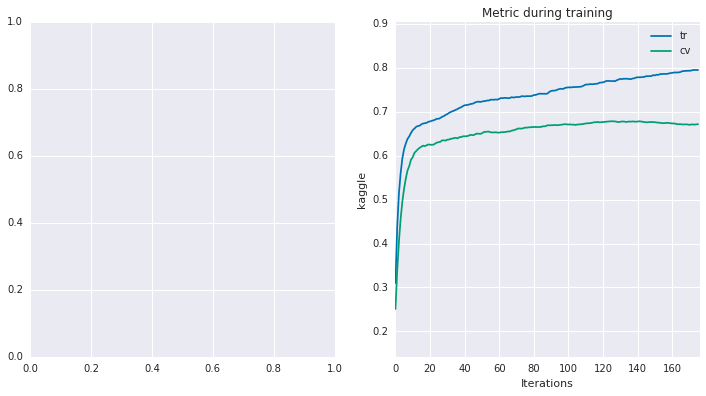

In [81]:
for ds, metrics in evals_result.items():
    for m_name, m_list in metrics.items():
        if m_name=='kaggle':
            for i,m in enumerate(m_list):
                m_list[i] = m % (lgb_kaggle_metric.hack or 1e6)
        else:
            for i,m in enumerate(m_list):
                m_list[i] *= -1
                
canvas(12,6)
fig, (ax0, ax1) = plt.subplots(1,2)
#ax = lgb.plot_metric(evals_result, metric='binary_logloss', ax=ax0);
ax = lgb.plot_metric(evals_result, metric='kaggle', ax=ax1);
canvas(12,12)

0.6149579310264814


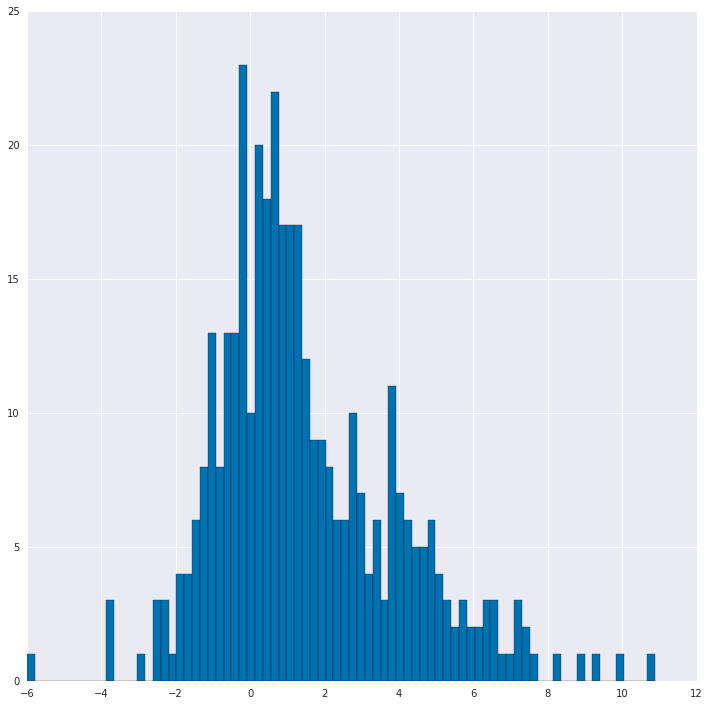

In [82]:
P['guess'] = bst.predict(F_)*2-1
P.guess = P.guess*(np.abs(P.guess)>=0.0)

P['trade'] = P.guess*P.upDown1*P.absVal1

daily = P[ho].groupby('time').trade.sum()
print(daily.mean()/daily.std(ddof=0))
plt.hist(daily, bins=80);

### ~@~@~@~@~@~@~@~@~@~@~ local analysis of performance ~@~@~@~@~@~@~@~@~@~@~@~

In [46]:
#F_.to_pickle('/big/data/play/init9/F_.pkl')
#P.to_pickle('/big/data/play/init9/P.pkl')
F_ = pd.read_pickle('/big/data/play/init9/F_.pkl')
P = pd.read_pickle('/big/data/play/init9/P.pkl')

In [48]:
P['assetCodeId'] = P.assetCode.map(assetCodeIdAssign)

In [74]:
T = P[['time','assetCodeId','trade']].pivot('time','assetCodeId').trade

##### just the stocks with at least ~2000 nonnan days

In [73]:
Tsub = P[cv][['time','assetCodeId','trade']].pivot('time','assetCodeId').trade

In [62]:
xGoodStocks = set(((~T.isna()).sum()>800).nonzero()[0])

0.5804826154730346


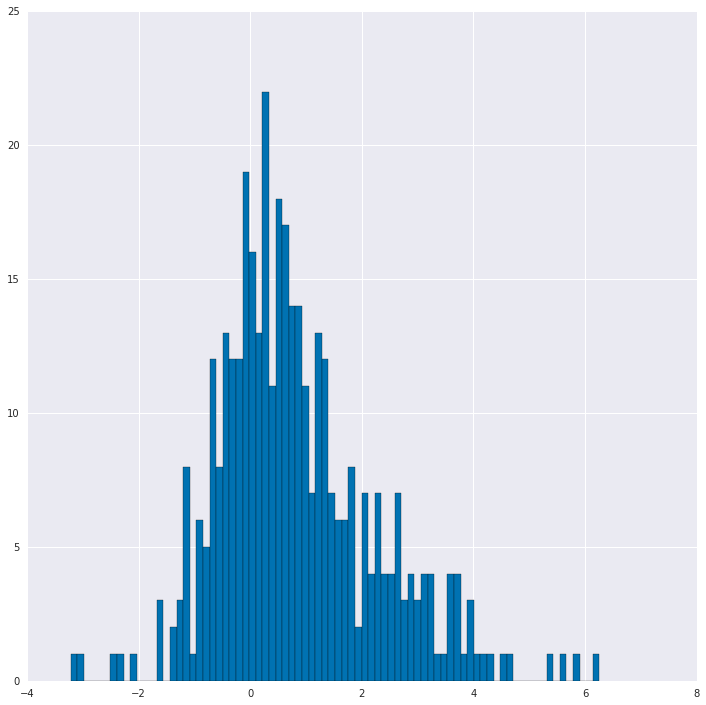

In [92]:
P1 = P.copy()
P1.guess = P1.guess * P1.assetCodeId.isin(xGoodStocks)
P1.guess = P1.guess*(np.abs(P1.guess)>=0.0)

P1['trade'] = P1.guess*P1.upDown1*P1.absVal1

daily = P1[ho].groupby('time').trade.sum()
print(daily.mean()/daily.std(ddof=0))
plt.hist(daily, bins=80);

##### some correlations idk

In [79]:
tret = Tsub.mean()
tvol = Tsub.std(ddof=0)
tshp = tret/tvol
tnum = (~Tsub.isna()).sum()

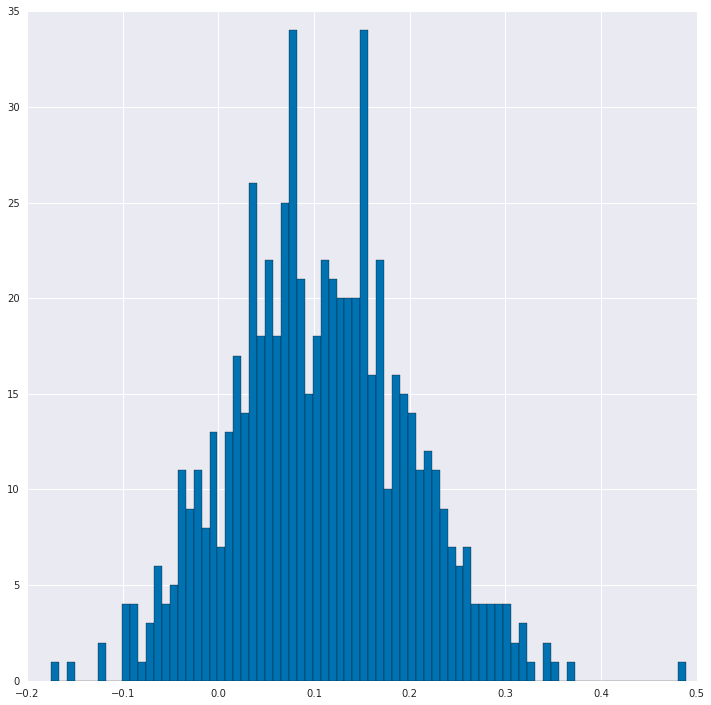

In [78]:
plt.hist(nonnans(tshp[tnum>800]), bins=80);

In [ ]:
Tcorr = T.corr(min_periods=1000)

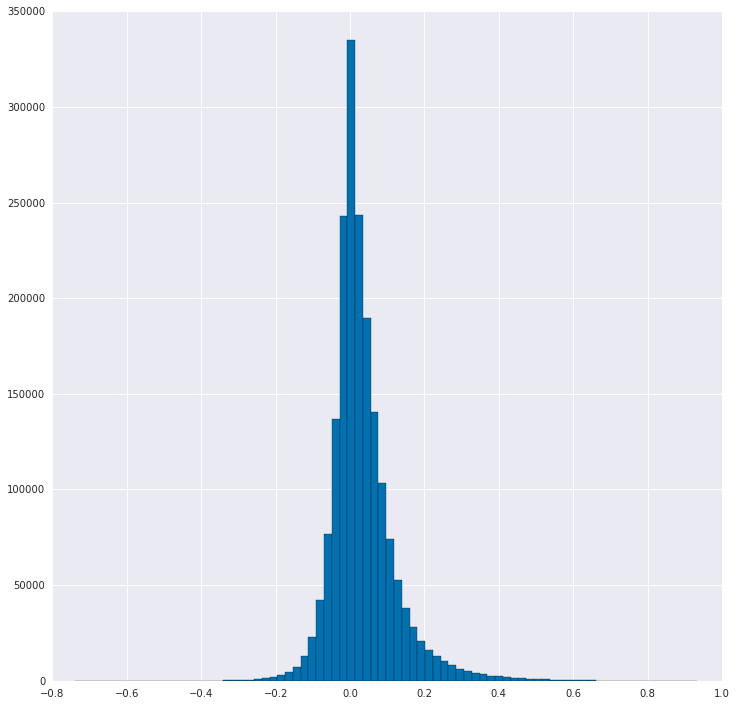

In [85]:
plt.hist(nonnans(offdiag(Tcorr.values)), bins=80);

## +-+-+-+-+-+-+-+-+-+-+-+-+-+-+- Prediction and submission +-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-

#### define our prdiction function:

In [57]:
def predict(F):
    return bst.predict(F[fSelection]) * 2 - 1

#### the rest of the administrative pipeline

In [66]:
def do_submission_loop():
    feat_iter = iter_features_templates(__env__.get_prediction_days(), U_=(U_,longterm))
    for i, (f, p) in enumerate(feat_iter):
        print_progress(i)
        p.confidenceValue = predict(F=f)
        __env__.predict(p)
        gc.collect()
do_submission_loop()

0.........10.........20.........30.........40.........50.........60.........70.........80.........90.........100.........110.........120.........130.........140.........150.........160.........170.........180.........190.........200.........210.........220.........230.........240.........250.........260.........270.........280.........290.........300.........310.........320.........330.........340.........350.........360.........370.........380.........390.........400.........410.........420.........430.........440.........450.........460.........470.........480.........490.........500.........510.........520.........530.........540.........550.........560.........570.........580.........590.........600.........610.........620.........630........

In [67]:
__env__.write_submission_file()

Your submission file has been saved. Once you `Commit` your Kernel and it finishes running, you can submit the file to the competition from the Kernel Viewer `Output` tab.


# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ LOCAL TESTING ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 

In [73]:
test = pd.read_pickle('../data/given/test.pkl')

In [74]:
X = pd.concat([day[0][['time','assetCode','returnsOpenPrevMktres10']] for day in test], axis=0)
X.reset_index(drop=True, inplace=True)

In [75]:
#Z = pd.concat([day[2] for day in test], axis=0)
#Z.reset_index(drop=True, inplace=True)

In [76]:
# all this cell just to make the target column

times = X.time.unique()
times10 = np.shift(times, -10)
times10map = dict(zip(times,times10))

Y = X.copy()
Y.time = X.time.map(times10map)
next10index = Y[~Y.time.isna()].set_index(['time','assetCode']).index

_ans = X.set_index(['time','assetCode']).loc[next10index].returnsOpenPrevMktres10.values
_ans = np.pad(_ans, pad_width=(0,len(X)-len(_ans)), mode='constant', constant_values=0.)
X['answer'] = _ans

In [77]:
X['guess'] = __env__._submission.confidenceValue.values * 2 - 1

In [78]:
X['universe'] = (~X.answer.isna()) & (np.abs(X.answer) < 2)

#X.answer = Z.returnsOpenNextMktres10.values
#X.universe = Z.universe.values

X['target'] = X.answer > 0
X['upDown'] = X.target * 2 - 1
X['upDown1'] = X.upDown * X.universe.astype(int)
X['absVal'] = np.abs(X.answer)
X['absVal1'] = X.absVal * X.universe
X['weight'] = X.absVal#.qtl()
X['weight1'] = X.weight * X.universe

In [79]:
X['trade'] = X.guess*X.upDown1*X.absVal1

0.10556716614607231


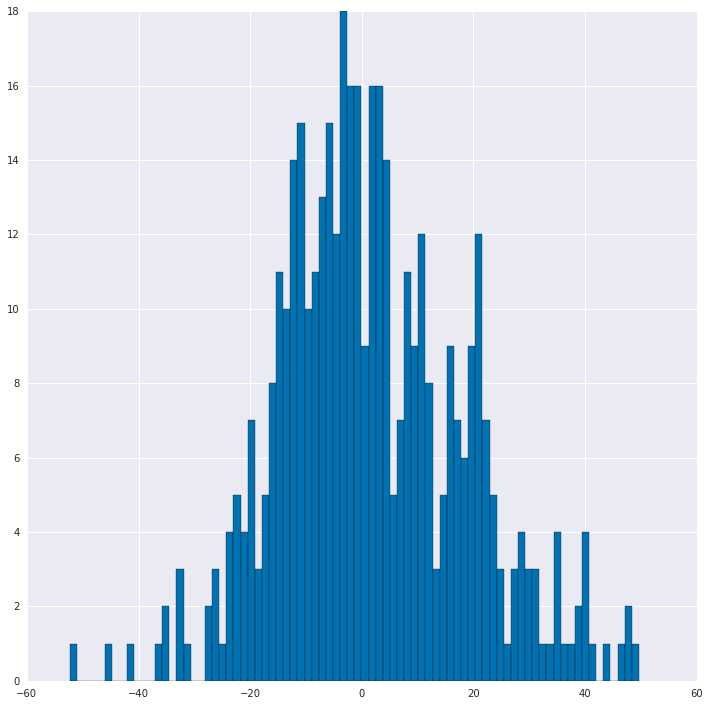

In [80]:
lb = X.time < '2018-09-01'
daily = X[lb].groupby('time').trade.sum()
print(daily.mean()/daily.std(ddof=0))
plt.hist(daily, bins=80);

# --------------------------------------- SCRATCH ----------------------------------------------------

In [65]:
F0['(oo0-cc0)'] = F0['(it,af,it{1},oo0,cc0){3/4}']

In [66]:
F0.drop(columns=[c for c in F0.columns if c not in fNewnewfault], inplace=True)

In [69]:
gc.collect()
df = F[F0.columns]
df0 = F0
eq = np.abs(df0.fillna(np.inf)-df.fillna(np.inf)).fillna(0)<1e-8

In [70]:
#pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)
eq.sum(axis=0)/len(eq)

volume                      1.000000
close                       1.000000
open                        1.000000
assetCodeId                 1.000000
assetNameId                 1.000000
cc                          1.000000
oo                          1.000000
cc0                         1.000000
oo0                         1.000000
cc_10                       1.000000
oo_10                       1.000000
cc0_10                      1.000000
oo0_10                      1.000000
dayOfYear                   1.000000
dayOfWeek                   1.000000
ooSince21                   1.000000
ooMaxSince21                1.000000
ooDrawdownSince21           1.000000
ooMinSince21                1.000000
ooSince62                   1.000000
ooMaxSince62                1.000000
ooDrawdownSince62           1.000000
ooMinSince62                1.000000
ooSince125                  1.000000
ooMaxSince125               1.000000
ooDrawdownSince125          1.000000
ooMinSince125               1.000000
o

In [57]:
dude = M[M.assetCode=='AAPL.O'][M.time<'2009-01-03'].tail(5)
set_basic_features(M=dude)
dude

,time,assetCode,assetName,volume,close,open,returnsOpenNextMktres10,universe,assetCodeId,assetNameId,cc,oo,cc0,oo0,cc_10,oo_10,cc0_10,oo0_10,dayOfYear,dayOfWeek
726443,2008-12-26 22:00:00+00:00,AAPL.O,Apple Inc,11043071.0,85.81,86.55,0.023792,1.0,3,3,0.009014,0.005213,0.005038,0.001207,-0.101741,-0.115534,-0.100484,-0.078656,361.0,4.0
728035,2008-12-29 22:00:00+00:00,AAPL.O,Apple Inc,24567225.0,86.61,86.62,-0.008313,1.0,3,3,0.009280,0.000808,0.011972,-0.001201,-0.126304,-0.069885,-0.109256,-0.070672,364.0,0.0
729627,2008-12-30 22:00:00+00:00,AAPL.O,Apple Inc,34579620.0,86.29,87.42,0.008330,1.0,3,3,-0.003702,0.009193,-0.020864,0.010283,-0.093528,-0.093416,-0.130348,-0.078830,365.0,1.0
731221,2008-12-31 22:00:00+00:00,AAPL.O,Apple Inc,21715763.0,85.35,86.00,0.052227,1.0,3,3,-0.010953,-0.016377,-0.023658,-0.028226,-0.111633,-0.088947,-0.093581,-0.116575,366.0,2.0
732815,2009-01-02 22:00:00+00:00,AAPL.O,Apple Inc,26964210.0,90.75,85.58,-0.026166,1.0,3,3,0.061348,-0.004896,0.032733,-0.015290,0.017676,-0.061408,-0.029549,-0.053305,2.0,4.0


In [58]:
dude.oo.sum()

-0.0060578004450126009

In [63]:
c = '(oo0-cc0)'
guy = pd.concat({'time':P.time,'assetCodeId':F.assetCodeId,'df':df[c],'df0': df0[c],'cc0':df.cc0,'oo0':df.oo0}, axis=1)
guy[(guy.assetCodeId!=-1) & (df[c]!=df0[c])].pipe(lambda x: pd.concat([x, x.oo0-x.cc0], axis=1))

,assetCodeId,cc0,df,df0,oo0,time,0
732812,0,0.028696,1.256251e-02,-0.064784,4.125897e-02,2009-01-02 22:00:00+00:00,1.256251e-02
732813,1,-0.018934,-3.017972e-02,0.042388,-4.911375e-02,2009-01-02 22:00:00+00:00,-3.017972e-02
732814,2,-0.010750,1.986397e-02,0.021261,9.114077e-03,2009-01-02 22:00:00+00:00,1.986397e-02
732815,3,0.032733,-4.802233e-02,-0.004568,-1.528981e-02,2009-01-02 22:00:00+00:00,-4.802233e-02
732816,1564,-0.055761,1.097132e-01,0.002326,5.395219e-02,2009-01-02 22:00:00+00:00,1.097132e-01
732817,4,-0.017254,3.152896e-02,-0.011766,1.427474e-02,2009-01-02 22:00:00+00:00,3.152896e-02
732818,5,-0.017041,3.983991e-02,0.004516,2.279893e-02,2009-01-02 22:00:00+00:00,3.983991e-02
732819,7,-0.045668,4.680588e-02,-0.029059,1.138005e-03,2009-01-02 22:00:00+00:00,4.680588e-02
732820,2099,-0.042891,9.170951e-02,-0.053478,4.881807e-02,2009-01-02 22:00:00+00:00,9.170951e-02
732821,8,-0.008815,7.970818e-03,0.010375,-8.440820e-04,2009-01-02 22:00:00+00:00,7.970818e-03


In [58]:
for c in combos.omo(5):
    name = '(it,af,it{{1}},oo0,cc0){{{}}}'.format(combos.name.index(c))
    if name == '(it,af,it{1},oo0,cc0){3/4}':
        print(c)
        print(c@np.asarray([[0]*9,[1]*9,[2]*9,[4]*9,[8.]*9]))

[ 0  0  0  1 -1]
[-4. -4. -4. -4. -4. -4. -4. -4. -4.]
